## First benchmark

To benchmark: estimating disassembly indexes for increasing levels of complex peptidomes


        

In [1]:
from disassembly.simulate_proteolysis import enzyme_set, enzyme, amino_acids


enzymes1 = enzyme_set(
    [
        enzyme({"K": 1}, "K protease"),
    ],
    [1],
    [1],
)

enzymes2 = enzyme_set(
    [
        enzyme({"K": 0.5, "R": 0.5}, "K+R protease"),
    ],
    [1],
    [1],
)


enzymes3 = enzyme_set(
    [
        enzyme({"V": 0.3, "I": 0.3, "A": 0.2, "T": 0.1}, "V+I+A+T protease"),
    ],
    [1],
    [1],
)

random = enzyme_set(
    [enzyme({aa: 1 / len(amino_acids) for aa in amino_acids.values()}, "random")],
    [1],
    [1],
)

In [2]:
protein = "MAHVRGLQLPGCLALAALCSLVHSQHVFLAPQQARSLLQRVRRANTFLEEVRKGNLERECVEETCSYEEAFEALESSTATDVFWAKYTACETARTPRDKLAACLEGNCAEGLGTNYRGHVNITRSGIECQLWRSRYPHKPEINSTTHPGADLQENFCRNPDSSTTGPWCYTTDPTVRRQECSIPVCGQDQVTVAMTPRSEGSSVNLSPPLEQCVPDRGQQYQGRLAVTTHGLPCLAWASAQAKALSKHQDFNSAVQLVENFCRNPDGDEEGVWCYVAGKPGDFGYCDLNYCEEAVEEETGDGLDEDSDRAIEGRTATSEYQTFFNPRTFGSGEADCGLRPLFEKKSLEDKTERELLESYIDGRIVEGSDAEIGMSPWQVMLFRKSPQELLCGASLISDRWVLTAAHCLLYPPWDKNFTENDLLVRIGKHSRTRYERNIEKISMLEKIYIHPRYNWRENLDRDIALMKLKKPVAFSDYIHPVCLPDRETAASLLQAGYKGRVTGWGNLKETWTANVGKGQPSVLQVVNLPIVERPVCKDSTRIRITDNMFCAGYKPDEGKRGDACEGDSGGPFVMKSPFNNRWYQMGIVSWGEGCDRDGKYGFYTHVFRLKKWIQKVIDQFGE"

In [3]:
from disassembly.simulate_proteolysis import simulate_proteolysis
from disassembly.estimate_weights import estimate_weights
from disassembly.disassembly import (
    get_disassembly,
    get_disassembly_indexes_mc,
)

results = {}
test_names = ["simple", "medium", "complex", "random"]
iterations = 20
simulated_peptidomes = {}
simulated_graphs = {}
generated_graphs = {}

# Simulating peptidomes
for test_name, enzymes in zip(test_names, [enzymes1, enzymes2, enzymes3, random]):
    simulated_peptidomes[test_name] = {}
    simulated_graphs[test_name] = {}
    for iteration in range(iterations):
        print(f"Running {test_name} {iteration}")
        simulated_peptidome, simulated_graph = simulate_proteolysis(
            protein,
            enzymes,
            n_start=3,
            n_generate=250,
            endo_or_exo_probability=[0.9, 0.1],
        )
        simulated_peptidomes[test_name][iteration] = simulated_peptidome
        simulated_graphs[test_name][iteration] = simulated_graph


Running simple 0
 249 / 250 (218)
134 unique peptides. 253 total
Running simple 1
 249 / 250 (225)
138 unique peptides. 253 total
Running simple 2
 249 / 250 (242)
136 unique peptides. 253 total
Running simple 3
 249 / 250 (229)
126 unique peptides. 253 total
Running simple 4
 248 / 250 (238)
122 unique peptides. 253 total
Running simple 5
 249 / 250 (227)
135 unique peptides. 253 total
Running simple 6
 249 / 250 (223)
142 unique peptides. 253 total
Running simple 7
 249 / 250 (227)
118 unique peptides. 253 total
Running simple 8
 249 / 250 (235)
133 unique peptides. 253 total
Running simple 9
 249 / 250 (221)
146 unique peptides. 253 total
Running simple 10
 248 / 250 (238)
127 unique peptides. 253 total
Running simple 11
 248 / 250 (233)
148 unique peptides. 253 total
Running simple 12
 249 / 250 (225)
142 unique peptides. 254 total
Running simple 13
 249 / 250 (228)
146 unique peptides. 253 total
Running simple 14
 249 / 250 (236)
143 unique peptides. 254 total
Running simple 15
 2

# Algorithmic method

In [4]:

# Running estimation
for test_name, enzymes in zip(test_names, [enzymes1, enzymes2, enzymes3, random]):
    results[test_name] = {}
    generated_graphs[test_name] = {}
    for iteration in range(iterations):
        results[test_name][iteration] = {}
        print(test_name, iteration)
        G, kls, generated, weights = estimate_weights(
            P=simulated_peptidomes[test_name][iteration],
            meta_enzyme=enzymes.meta_enzyme,
            exo_mult_factor=2,
            lr=1,
            n_iterations=1000,
            alpha=0.05,
        )
        generated_graphs[test_name][iteration] = G
        results[test_name][iteration]["kl"] = kls
        results[test_name][iteration]["rdi"] = get_disassembly_indexes_mc(
            simulated_graphs[test_name][iteration], 10000
        )
        results[test_name][iteration]["rd"] = get_disassembly(
            simulated_peptidomes[test_name][iteration],
            results[test_name][iteration]["rdi"],
        )
        results[test_name][iteration]["edi"] = get_disassembly_indexes_mc(G, 10000)
        results[test_name][iteration]["ed"] = get_disassembly(
            simulated_peptidomes[test_name][iteration],
            results[test_name][iteration]["edi"],
        )

simple 0
 19 / 1000 | 0.08, mean: 0.37 | Decreasing | nz: 713

/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


 99 / 1000 | 0.01, mean: 0.01 | Plateau | nz: 776256
Learning rate decreased to 0.5
 122 / 1000 | 0.00, mean: 0.00 | Plateau | nz: 1058
 Averaged DI: 2.23

 Averaged DI: 3.17
simple 1
 99 / 1000 | 0.29, mean: 0.20 | Increasing | nz: 821
Learning rate decreased to 0.5
 174 / 1000 | 0.00, mean: 0.00 | Plateau | nz: 9529477
Learning rate decreased to 0.25
 196 / 1000 | 0.00, mean: 0.00 | Plateau | nz: 951
 Averaged DI: 2.14

 Averaged DI: 3.21
simple 2
 99 / 1000 | 0.06, mean: 0.04 | Plateau | nz: 985909
Learning rate decreased to 0.5
 174 / 1000 | 0.00, mean: 0.00 | Plateau | nz: 1091086
Learning rate decreased to 0.25
 180 / 1000 | 0.00, mean: 0.00 | Plateau | nz: 1089
 Averaged DI: 2.19

 Averaged DI: 3.33
simple 3
 99 / 1000 | 0.02, mean: 0.02 | Plateau | nz: 715732
Learning rate decreased to 0.5
 130 / 1000 | 0.00, mean: 0.00 | Plateau | nz: 844
 Averaged DI: 2.15

 Averaged DI: 3.08
simple 4
 99 / 1000 | 0.39, mean: 0.13 | Plateau | nz: 887630
Learning rate decreased to 0.5
 174 / 1

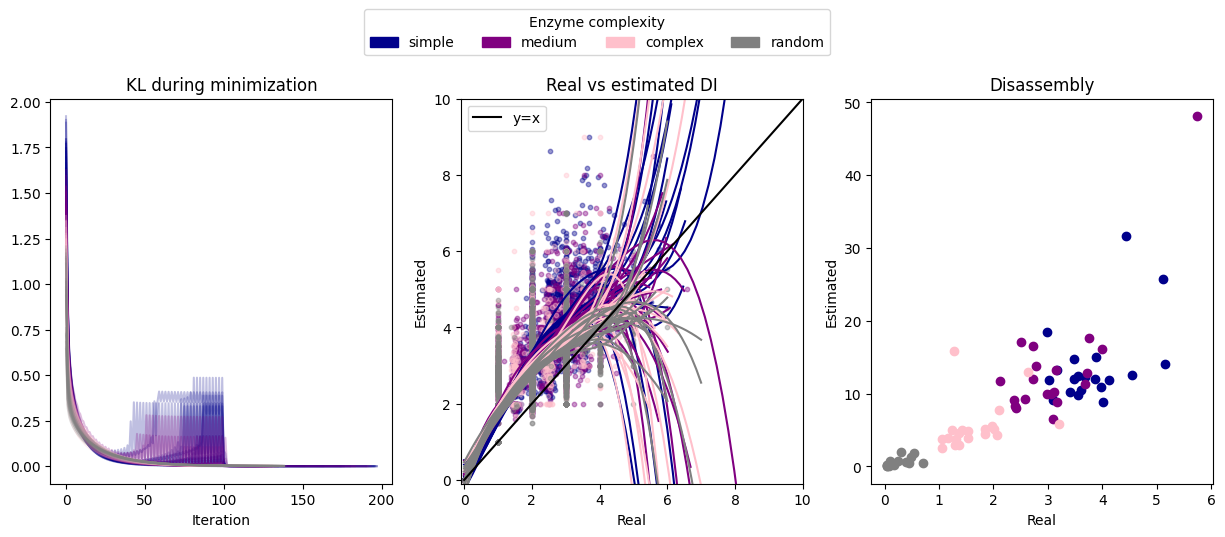

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from disassembly.util import get_nrmse

# Plotting KL-div
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
colors = ["darkblue", "purple", "pink", "gray"]

for i, test_name in enumerate(test_names):
    for iteration in range(iterations):
        axs[0].plot(
            results[test_name][iteration]["kl"],
            label=test_name,
            c=colors[i],
            alpha=0.25,
        )

# plotting corr DI
nrmse = {}
for i, test_name in enumerate(test_names):
    nrmse[test_name] = {}
    for iteration in range(iterations):
        real_di = results[test_name][iteration]["rdi"]
        estimated_di = results[test_name][iteration]["edi"]

        r_di = []
        e_di = []
        for sequence in real_di.keys():
            r_di.append(real_di[sequence])
            e_di.append(estimated_di[sequence])

        regress = np.polyfit(r_di, e_di, 4)

        axs[1].plot(
            np.linspace(0, max(e_di)),
            regress[0] * np.linspace(0, max(e_di)) ** 4
            + regress[1] * np.linspace(0, max(e_di)) ** 3
            + regress[2] * np.linspace(0, max(e_di)) ** 2
            + regress[3] * np.linspace(0, max(e_di))
            + regress[4],
            color=colors[i],
        )
        axs[1].scatter(r_di, e_di, c=colors[i], alpha=0.4, s=10)
        nrmse[test_name][iteration] = get_nrmse(r_di, e_di)

axs[1].plot(np.linspace(0, 50, 100), np.linspace(0, 50, 100), "black", label="y=x")
axs[1].legend()

# plotting real vs estimated disassembly
for i, test_name in enumerate(test_names):
    for iteration in range(iterations):
        real_d = results[test_name][iteration]["rd"]
        estimated_d = results[test_name][iteration]["ed"]

        axs[2].scatter(real_d, estimated_d, color=colors[i])


axs[0].set_title("KL during minimization")
axs[0].set_xlabel("Iteration")
axs[1].set_title("Real vs estimated DI")
axs[1].set_xlabel("Real")
axs[1].set_ylabel("Estimated")
axs[2].set_title("Disassembly")
axs[2].set_xlabel("Real")
axs[2].set_ylabel("Estimated")
axs[1].set_xlim([-.1, 10])
axs[1].set_ylim([-.1, 10])

import matplotlib.patches as mpatches

patches = []
for test_name, color in zip(test_names, colors):
    patches.append(mpatches.Patch(color=color, label=test_name))

plt.legend(
    handles=patches,
    bbox_to_anchor=(-0.1, 1.25),
    ncol=4,
    title="Enzyme complexity",
)

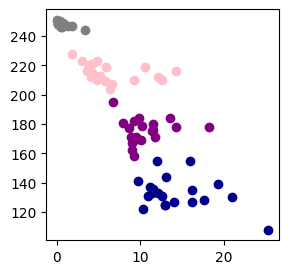

In [42]:
fig = plt.figure(figsize=(3, 3))
for i, test_name in enumerate(test_names):
    for iteration in range(iterations):
        edi = results[test_name][iteration]["ed"]
        n_pep = len(simulated_peptidomes[test_name][iteration].keys())
        plt.scatter(edi, n_pep, c=colors[test_names.index(test_name)])

# Gradient descent

In [6]:
from disassembly.estimate_weights_gd import WeightEstimatorGD

wegd = WeightEstimatorGD(lr=0.1, n_iterations=500, lam=0.1)

for test_name, enzymes in zip(test_names, [enzymes1, enzymes2, enzymes3, random]):
    results[test_name] = {}
    generated_graphs[test_name] = {}
    for iteration in range(iterations):
        print(test_name, iteration)
        results[test_name][iteration] = {}
        G = wegd.run(simulated_peptidomes[test_name][iteration], verbose=True)
        losses = wegd.losses
        
        generated_graphs[test_name][iteration] = G
        results[test_name][iteration]["kl"] = losses
        results[test_name][iteration]["rdi"] = get_disassembly_indexes_mc(
            simulated_graphs[test_name][iteration], 10000
        )
        results[test_name][iteration]["rd"] = get_disassembly(
            simulated_peptidomes[test_name][iteration],
            results[test_name][iteration]["rdi"],
        )
        results[test_name][iteration]["edi"] = get_disassembly_indexes_mc(G, 10000)

        results[test_name][iteration]["ed"] = get_disassembly(
            simulated_peptidomes[test_name][iteration],
            results[test_name][iteration]["edi"],
        )

simple 0
 499 / 500 | 0.31, kl: 0.01, reg: 0.30  | nz: 406 | 
 Averaged DI: 2.23

 Averaged DI: 2.40
simple 1
 499 / 500 | 0.47, kl: 0.00, reg: 0.47  | nz: 363 | 
 Averaged DI: 2.14

 Averaged DI: 2.52
simple 2
 499 / 500 | 0.34, kl: 0.00, reg: 0.34  | nz: 374 | 
 Averaged DI: 2.19

 Averaged DI: 2.44
simple 3
 499 / 500 | 0.33, kl: 0.01, reg: 0.32  | nz: 355 | 
 Averaged DI: 2.16

 Averaged DI: 2.41
simple 4
 499 / 500 | 0.32, kl: 0.01, reg: 0.30  | nz: 403 | 
 Averaged DI: 2.17

 Averaged DI: 2.30
simple 5
 499 / 500 | 0.29, kl: 0.01, reg: 0.28  | nz: 317 | 
 Averaged DI: 2.13

 Averaged DI: 2.34
simple 6
 499 / 500 | 0.32, kl: 0.01, reg: 0.32  | nz: 431 | 
 Averaged DI: 2.31

 Averaged DI: 2.59
simple 7
 499 / 500 | 0.31, kl: 0.00, reg: 0.30  | nz: 342 | 
 Averaged DI: 2.17

 Averaged DI: 2.53
simple 8
 499 / 500 | 0.38, kl: 0.00, reg: 0.37  | nz: 423 | 
 Averaged DI: 2.35

 Averaged DI: 2.53
simple 9
 499 / 500 | 0.40, kl: 0.00, reg: 0.40  | nz: 371 | 
 Averaged DI: 2.11

 Averaged

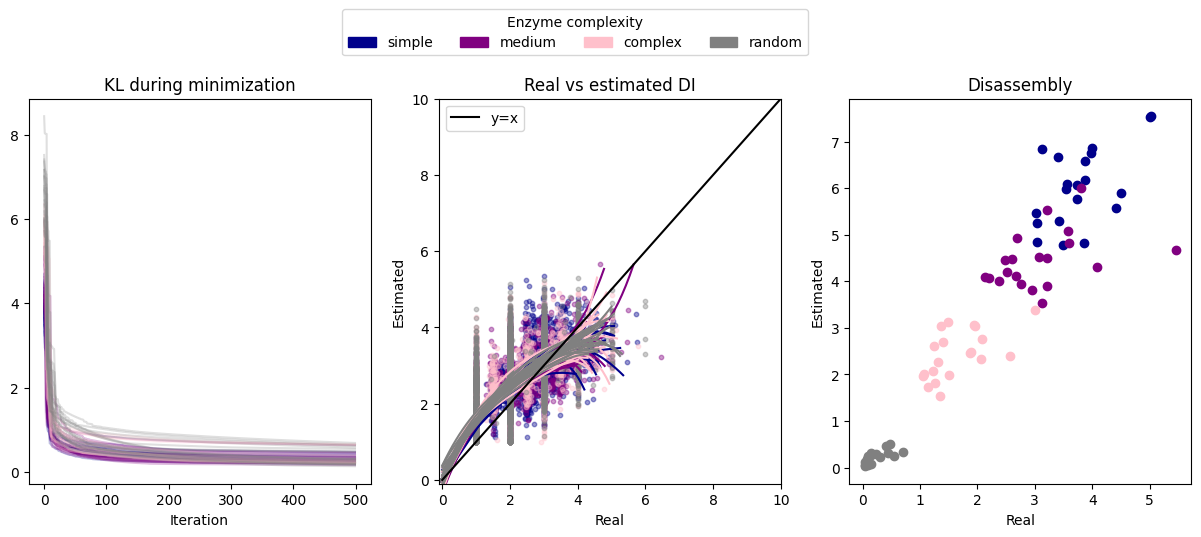

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from disassembly.util import get_nrmse

# Plotting KL-div
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
colors = ["darkblue", "purple", "pink", "gray"]

for i, test_name in enumerate(test_names):
    for iteration in range(iterations):
        axs[0].plot(
            results[test_name][iteration]["kl"],
            label=test_name,
            c=colors[i],
            alpha=0.25,
        )

# plotting corr DI
nrmse = {}
for i, test_name in enumerate(test_names):
    nrmse[test_name] = {}
    for iteration in range(iterations):
        real_di = results[test_name][iteration]["rdi"]
        estimated_di = results[test_name][iteration]["edi"]

        r_di = []
        e_di = []
        for sequence in real_di.keys():
            r_di.append(real_di[sequence])
            e_di.append(estimated_di[sequence])

        regress = np.polyfit(r_di, e_di, 4)

        axs[1].plot(
            np.linspace(0, max(e_di)),
            regress[0] * np.linspace(0, max(e_di)) ** 4
            + regress[1] * np.linspace(0, max(e_di)) ** 3
            + regress[2] * np.linspace(0, max(e_di)) ** 2
            + regress[3] * np.linspace(0, max(e_di))
            + regress[4],
            color=colors[i],
        )
        axs[1].scatter(r_di, e_di, c=colors[i], alpha=0.4, s=10)
        nrmse[test_name][iteration] = get_nrmse(r_di, e_di)

axs[1].plot(np.linspace(0, 12, 100), np.linspace(0, 12, 100), "black", label="y=x")
axs[1].legend()

# plotting real vs estimated disassembly
for i, test_name in enumerate(test_names):
    for iteration in range(iterations):
        real_d = results[test_name][iteration]["rd"]
        estimated_d = results[test_name][iteration]["ed"]

        axs[2].scatter(real_d, estimated_d, color=colors[i])


axs[0].set_title("KL during minimization")
axs[0].set_xlabel("Iteration")
axs[1].set_title("Real vs estimated DI")
axs[1].set_xlabel("Real")
axs[1].set_ylabel("Estimated")
axs[2].set_title("Real (color) vs estimated (black) disassembly")
axs[2].set_title("Disassembly")
axs[2].set_xlabel("Real")
axs[2].set_ylabel("Estimated")
axs[1].set_xlim([-.1, 10])
axs[1].set_ylim([-.1, 10])

import matplotlib.patches as mpatches

patches = []
for test_name, color in zip(test_names, colors):
    patches.append(mpatches.Patch(color=color, label=test_name))

plt.legend(
    handles=patches,
    bbox_to_anchor=(-0.1, 1.25),
    ncol=4,
    title="Enzyme complexity",
)

Endo / exo ratio: 0.9490977858324797
Endo / exo ratio: 0.8088435004617307
Endo / exo ratio: 0.9559411248659714
Endo / exo ratio: 0.8351758264897873
Endo / exo ratio: 0.922431058388538
Endo / exo ratio: 0.7745108521330054
Endo / exo ratio: 0.9047172225539538
Endo / exo ratio: 0.831614177548557
Endo / exo ratio: 0.9529411764705882
Endo / exo ratio: 0.763595166163142
Endo / exo ratio: 0.9539135563231949
Endo / exo ratio: 0.8451861506205021
Endo / exo ratio: 0.9312213039485767
Endo / exo ratio: 0.8073261255446184
Endo / exo ratio: 0.9443170133670806
Endo / exo ratio: 0.7954878850725884
Endo / exo ratio: 0.8990825688073395
Endo / exo ratio: 0.7798976268031642
Endo / exo ratio: 0.9182516140289653
Endo / exo ratio: 0.78086094112682
Endo / exo ratio: 0.9285902503293808
Endo / exo ratio: 0.7584841023445027
Endo / exo ratio: 0.9373139555244265
Endo / exo ratio: 0.8354080221300139
Endo / exo ratio: 0.9566064470421537
Endo / exo ratio: 0.8290243763850219
Endo / exo ratio: 0.9417467398764585
Endo /

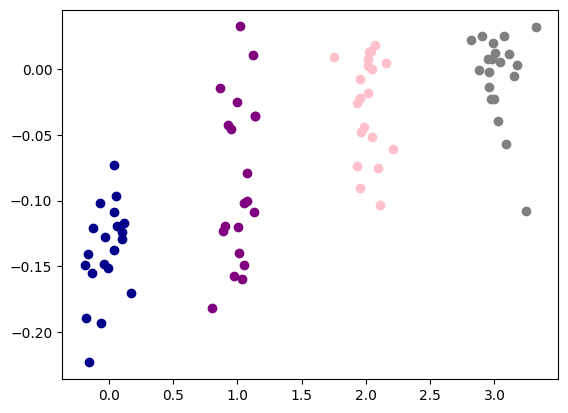

In [16]:
from disassembly.cut_site import get_p1
fig = plt.figure()
for i, test_name in enumerate(test_names):
    for iteration in range(iterations):
        simulated_graph = simulated_graphs[test_name][iteration]
        graph = generated_graphs[test_name][iteration]
        r_p1, r_exo, r_endo = get_p1(simulated_graph, 1000)
        e_p1, e_exo, e_endo = get_p1(graph, 1000)
        plt.scatter(i + np.random.normal(0, 0.1), (e_endo / (e_exo + e_endo)) - (r_endo/(r_endo + r_exo)), color=colors[i])



# Peptidomes

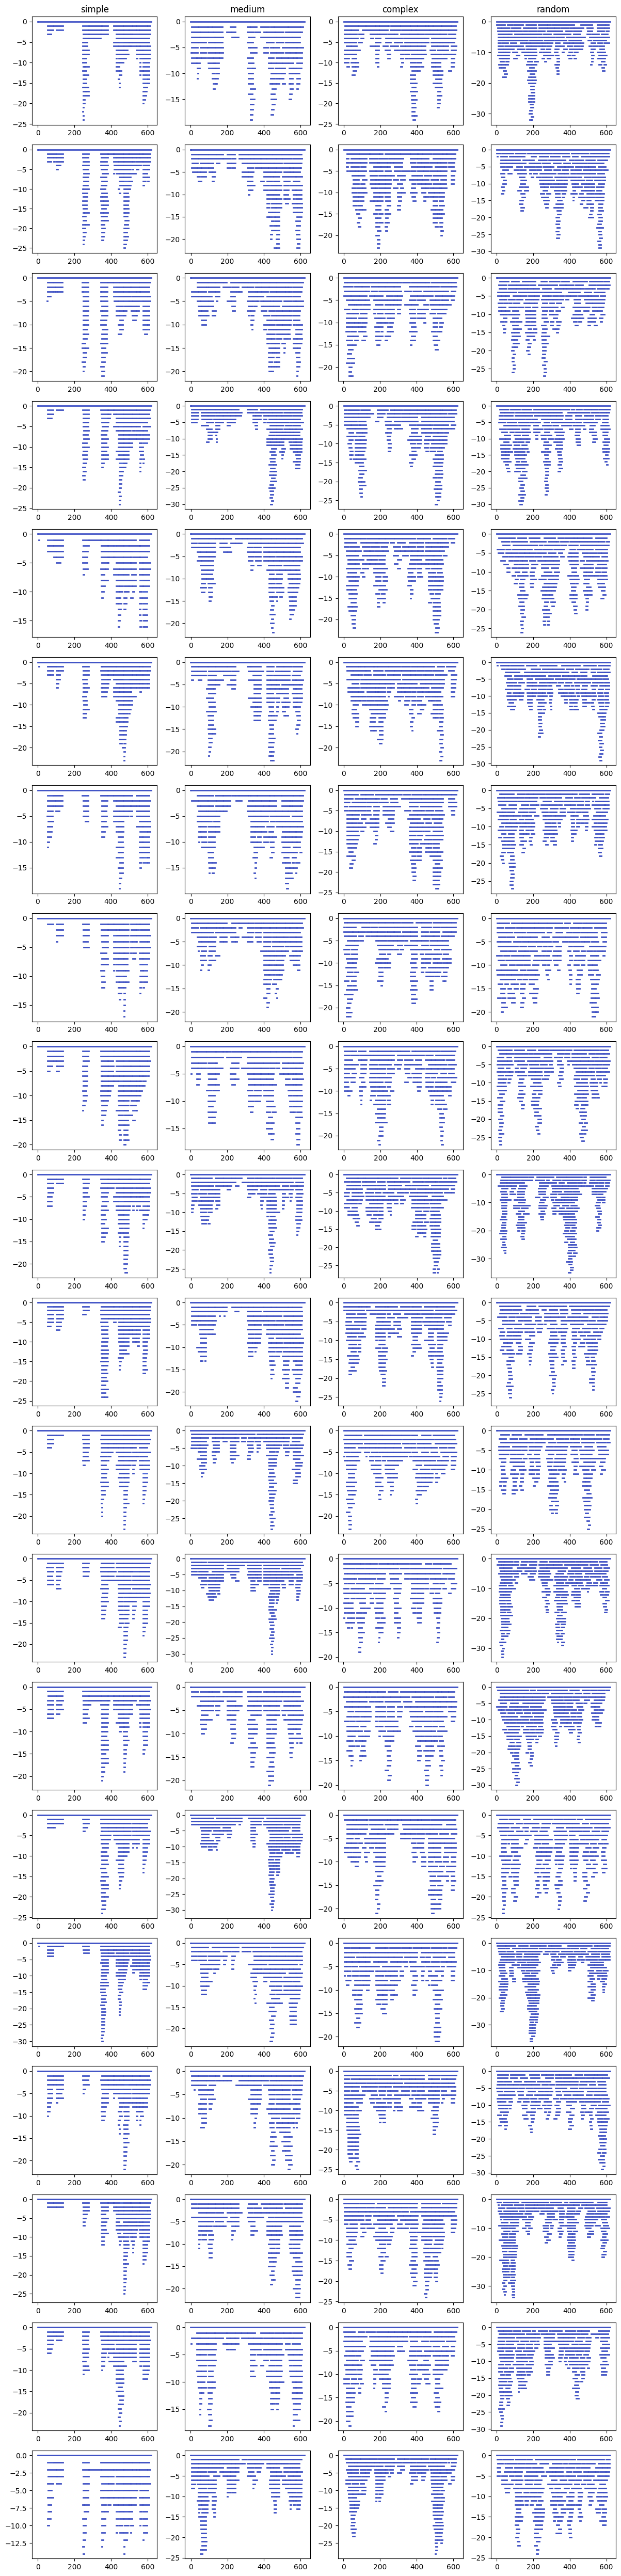

In [45]:
from disassembly.util import plot_peptidome

fig, axs = plt.subplots(
    iterations, len(test_names), figsize=(len(test_names) * 3, iterations * 2.5)
)
for iteration in range(iterations):
    for test_name in test_names:
        ax = axs[iteration, test_names.index(test_name)]
        if iteration == 0:
            ax.set_title(test_name)
        plot_peptidome(protein, simulated_peptidomes[test_name][iteration], ax)
plt.tight_layout()